# Spatial analysis of housing prices in Portuguese municipalities

## Environment & libraries

In [28]:
# Core
import pandas as pd
import numpy as np

# Spatial
import geopandas as gpd
from libpysal.weights import Queen, Rook
from esda import Moran, Moran_Local

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

# Interactive maps
import folium
from folium.plugins import MeasureControl
import branca.colormap as cm

# Settings
pd.set_option("display.max_columns", None)

# 1. Reading Spatial Data


In [29]:
caop_path = "Shapefiles/Cont_Conc_CAOP2022.shp"
gdf = gpd.read_file(caop_path)

gdf.head()

,DICO,Concelho,Distrito,N_Freguesi,NUTSIII,NUTSII,NUTSI,Alt_Max,Alt_Min,Area_ha,Perim_km,geometry
0,0101,Águeda,Aveiro,11,Região de Aveiro,Centro,Continente,762,4,33527.44,105,"POLYGON ((-20560.758 113803.912, -20550.798 11..."
1,0102,Albergaria-a-Velha,Aveiro,6,Região de Aveiro,Centro,Continente,425,0,15882.50,82,"POLYGON ((-26966.491 123573.381, -26964.759 12..."
2,0103,Anadia,Aveiro,10,Região de Aveiro,Centro,Continente,525,13,21663.48,75,"POLYGON ((-17449.514 93729.645, -17450.254 937..."
3,0104,Arouca,Aveiro,16,Área Metropolitana do Porto,Norte,Continente,1222,50,32910.52,118,"POLYGON ((-7133.618 149431.412, -7096.198 1494..."
4,0105,Aveiro,Aveiro,10,Região de Aveiro,Centro,Continente,78,0,19757.57,77,"POLYGON ((-42619.981 117138.132, -42536.222 11..."


In [30]:
# Inspect Geometry
gdf.crs

<Projected CRS: EPSG:3763>
Name: ETRS89 / Portugal TM06
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Portugal - mainland - onshore.
- bounds: (-9.56, 36.95, -6.19, 42.16)
Coordinate Operation:
- name: Portugual TM06
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# 2. Reading and preparing housing price data

In [31]:
prices = pd.read_csv("housing_prices.csv")

# Drop useless row
prices = prices.drop(0)

# Change header
new_header = prices.iloc[0]
prices = prices[1:]
prices.columns = new_header

# Only need 3rd Quarter 2025
prices = prices.loc[:, prices.columns.notna()]
prices = prices.drop(2)

# Keep only municipalities (concelhos)
prices["COD (NUTS2024)"] = prices["COD (NUTS2024)"].astype(str)

# 7-digit NUTS codes
prices_mun = prices[prices["COD (NUTS2024)"].str.len() == 7].copy()

# Rename columns
prices_mun = prices_mun.rename(columns={
    "Median value per m² of dwellings sales (in the last 12 months)": "price_m2",
    "1st Quartile of dwellings sales per m² (in the last 12 months)": "q1_m2",
    "3rd Quartile of dwellings sales per m² (in the last 12 months)": "q3_m2"
})

prices_mun.head()

1,COD (NUTS2024),Designation,q1_m2,price_m2,q3_m2
7,1111601,Arcos de Valdevez,392,913,1 509
8,1111602,Caminha,1 076,1 544,2 059
9,1111603,Melgaço,259,530,1 042
10,1111604,Monção,594,1 138,1 625
11,1111605,Paredes de Coura,349,777,1 290


In [32]:
# Parse strings to float
prices_mun["q1_m2"] = pd.to_numeric(
    prices_mun["q1_m2"].str.replace(" ", "", regex=False),
    errors="coerce"
)

prices_mun["q3_m2"] = pd.to_numeric(
    prices_mun["q3_m2"].str.replace(" ", "", regex=False),
    errors="coerce"
)

prices_mun["price_m2"] = pd.to_numeric(
    prices_mun["price_m2"].str.replace(" ", "", regex=False),
    errors="coerce"
)

# IQR
prices_mun["iqr_m2"] = prices_mun["q3_m2"] - prices_mun["q1_m2"]

prices_mun.head()

1,COD (NUTS2024),Designation,q1_m2,price_m2,q3_m2,iqr_m2
7,1111601,Arcos de Valdevez,392.0,913.0,1509.0,1117.0
8,1111602,Caminha,1076.0,1544.0,2059.0,983.0
9,1111603,Melgaço,259.0,530.0,1042.0,783.0
10,1111604,Monção,594.0,1138.0,1625.0,1031.0
11,1111605,Paredes de Coura,349.0,777.0,1290.0,941.0


# 3. Joining Spatial and Statistical data

In [33]:
gdf = gdf.merge(
    prices_mun,
    left_on="Concelho",
    right_on="Designation",
    how="left"
)

In [34]:
# Verify empty values
gdf["price_m2"].isna().sum(), gdf["iqr_m2"].isna().sum()

(np.int64(1), np.int64(1))

In [35]:
gdf = gdf.dropna(subset=["price_m2", "iqr_m2"]).copy()
len(gdf)

278

# 4. Cloropeth Map

(np.float64(-133257.43192999973),
 np.float64(176195.10553000006),
 np.float64(-329229.2325699995),
 np.float64(304908.19597000023))

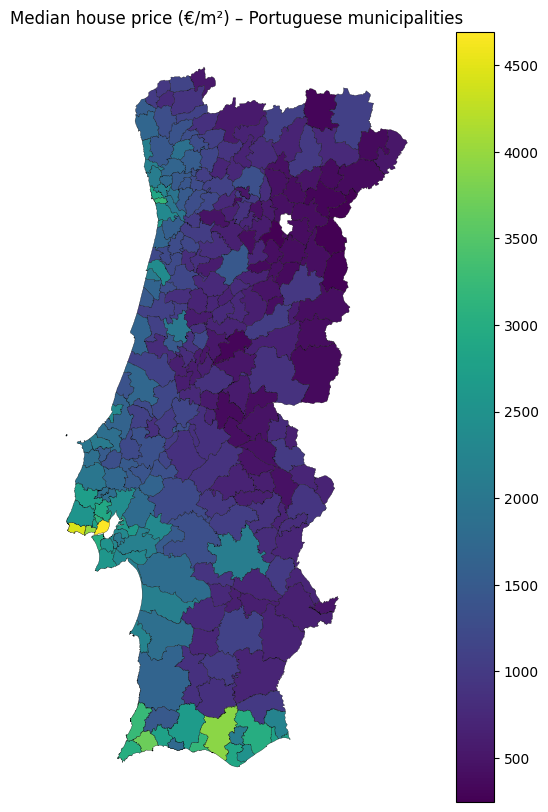

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
gdf.plot(
    column="price_m2",
    cmap="viridis",
    legend=True,
    ax=ax,
    edgecolor="black",
    linewidth=0.2
)
ax.set_title("Median house price (€/m²) – Portuguese municipalities")
ax.axis("off")

# 5. Global spatial autocorrelation
## 5.1 Spatial weights (Queen contiguity)

In [37]:
w = Queen.from_dataframe(gdf)
w.transform = "r"

C:\Users\tide2\AppData\Local\Temp\ipykernel_26100\3440755412.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
c:\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


## 5.1 Moran's I

In [38]:
y_price = gdf["price_m2"].values
y_iqr = gdf["iqr_m2"].values

mi_price = Moran(y_price, w)
mi_iqr = Moran(y_iqr, w)

mi_price.I, mi_price.p_sim


(np.float64(0.7736334103072767), np.float64(0.001))

In [39]:
mi_iqr.I, mi_iqr.p_sim

(np.float64(0.5182832479812765), np.float64(0.001))

# 6. Local Spatial Correlation
## 6.1 Moran's I

In [40]:
np.random.seed(42)
lisa_price = Moran_Local(y_price, w)

In [41]:
gdf["lisa_I"] = lisa_price.Is
gdf["lisa_p"] = lisa_price.p_sim
gdf["lisa_q"] = lisa_price.q

In [42]:
def lisa_cluster(row):
    if row["lisa_p"] > 0.05:
        return "Not significant"
    if row["lisa_q"] == 1:
        return "High-High"
    if row["lisa_q"] == 2:
        return "Low-High"
    if row["lisa_q"] == 3:
        return "Low-Low"
    if row["lisa_q"] == 4:
        return "High-Low"

gdf["lisa_cluster"] = gdf.apply(lisa_cluster, axis=1)

In [43]:
gdf.loc[gdf["lisa_p"] <= 0.05, "lisa_q"].value_counts()

lisa_q
3    71
1    45
2     1
4     1
Name: count, dtype: int64

## 6.2 Cluster Map

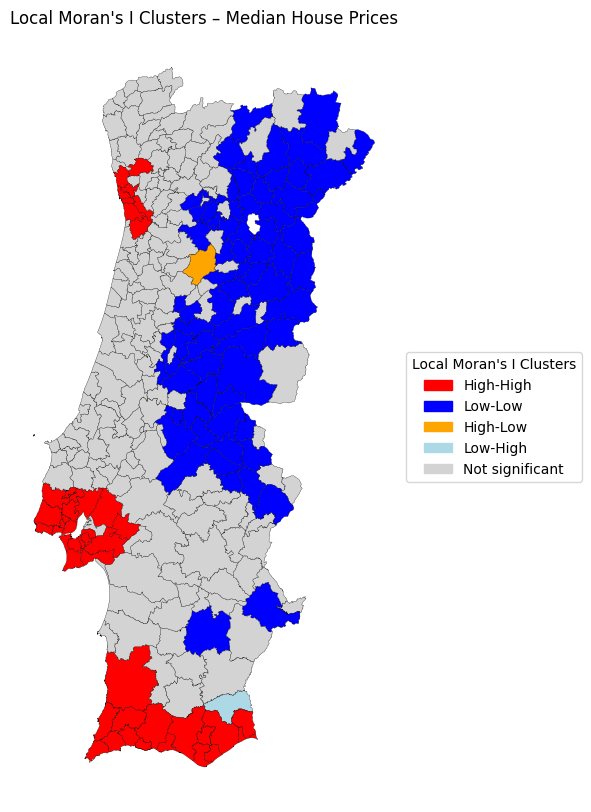

In [44]:
cluster_colors = {
    "High-High": "red",
    "Low-Low": "blue",
    "High-Low": "orange",
    "Low-High": "lightblue",
    "Not significant": "lightgrey"
}

fig, ax = plt.subplots(1, 1, figsize=(8, 10))
gdf.plot(
    color=gdf["lisa_cluster"].map(cluster_colors),
    ax=ax,
    edgecolor="black",
    linewidth=0.2
)

legend_handles = [
    mpatches.Patch(color=color, label=label)
    for label, color in cluster_colors.items()
]

ax.legend(
    handles=legend_handles,
    title="Local Moran's I Clusters",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

ax.set_title("Local Moran's I Clusters – Median House Prices")
ax.axis("off")

plt.show()


# 7. Interactive Map

In [45]:
m = folium.Map(location=[39.7, -8.0], zoom_start=7, tiles=None)

folium.TileLayer("cartodbpositron", name="Light Map", control=True).add_to(m)
folium.TileLayer("OpenStreetMap", name="OpenStreetMap", control=True).add_to(m)

highlight_style = {
    "weight": 2,
    "color": "#2b8cbe",
    "fillOpacity": 0.85
}

gdf["price_fmt"] = gdf["price_m2"].apply(lambda x: f"{x:,.0f} €")

# LISA Legend
legend_html = """
<div style="
position: fixed;
bottom: 40px; left: 40px; width: 180px; height: 120px;
background-color: white;
border:2px solid grey;
z-index:9999;
font-size:14px;
padding: 10px;
">
<b>LISA Clusters</b><br>
<i style="background:#d7191c;width:12px;height:12px;display:inline-block"></i>
  High-High<br>
<i style="background:#2c7bb6;width:12px;height:12px;display:inline-block"></i>
  Low-Low<br>
<i style="background:#abd9e9;width:12px;height:12px;display:inline-block"></i>
  Low-High<br>
<i style="background:#fdae61;width:12px;height:12px;display:inline-block"></i>
  High-Low<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Title
title_html = """
<h3 align="center" style="font-size:18px">
<b>Spatial Distribution of Median Housing Prices and LISA Clusters (Continental Portugal)</b>
</h3>
"""

m.get_root().html.add_child(folium.Element(title_html))


# Median Price layer
min_price = gdf["price_m2"].min()
max_price = gdf["price_m2"].max()

colormap = cm.linear.OrRd_09.scale(min_price, max_price)
colormap.caption = "Median price (€/m²)"
colormap.add_to(m)

choropleth_layer = folium.FeatureGroup(name="Median Price", show=True)

folium.GeoJson(
    gdf,
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["price_m2"]),
        "color": "#555555",
        "weight": 0.5,
        "fillOpacity": 0.7,
    },
    highlight_function=lambda x: highlight_style,
    tooltip=folium.GeoJsonTooltip(
        fields=["Designation", "price_fmt"],
        aliases=["Municipality", "Median Price"],
        localize=True
    ),
).add_to(choropleth_layer)

choropleth_layer.add_to(m)

# LISA cluster layer
cluster_layer = folium.FeatureGroup(name="LISA Clusters", show=False)

folium.GeoJson(
    gdf,
    style_function=lambda feature: {
        "fillColor": cluster_colors[feature["properties"]["lisa_cluster"]],
        "color": "#555555",
        "weight": 0.5,
        "fillOpacity": 0.6,
    },
    highlight_function=lambda x: highlight_style,
    tooltip=folium.GeoJsonTooltip(
        fields=["Designation", "price_fmt", "lisa_cluster"],
        aliases=["Municipality", "Median Price", "LISA cluster"],
        localize=True
    )
).add_to(cluster_layer)

cluster_layer.add_to(m)

# layer control
folium.LayerControl(collapsed=False).add_to(m)

m.save("interactive_map_housing_prices.html")


# 8. OLS
## 8.1 Merge Income

In [46]:
income_2023 = pd.read_csv("income_2023.csv")

# Replace header
new_header = income_2023.iloc[0]
income_2023 = income_2023[1:]
income_2023.columns = new_header

# Drop useless row
income_2023.drop(1)

# Rename columns
income_2023 = income_2023.rename(columns={
    "Rendimento bruto declarado médio por agregado fiscal": "income_mean",
    "Código territorial": "COD",
    "Designação":"Designation"
})

# Drop unneeded columns
income_2023 = income_2023[['COD',"Designation",'income_mean']]

# Drop NaN
income_2023 = income_2023.dropna()
income_2023

# Merge with spatial dataframe
gdf = gdf.merge(
    income_2023[["COD","Designation","income_mean"]],
    left_on="DICO",
    right_on="COD",
    how="left"
)

In [47]:
# Drop extra columns
gdf = gdf.drop(columns=["COD", "Designation_x", "Designation_y"])
gdf.head()

,DICO,Concelho,Distrito,N_Freguesi,NUTSIII,NUTSII,NUTSI,Alt_Max,Alt_Min,Area_ha,Perim_km,geometry,COD (NUTS2024),q1_m2,price_m2,q3_m2,iqr_m2,lisa_I,lisa_p,lisa_q,lisa_cluster,price_fmt,income_mean
0,0101,Águeda,Aveiro,11,Região de Aveiro,Centro,Continente,762,4,33527.44,105,"POLYGON ((-20560.758 113803.912, -20550.798 11...",1910101,660.0,1190.0,1600.0,940.0,0.016688,0.253,3,Not significant,"1,190 €",20 751
1,0102,Albergaria-a-Velha,Aveiro,6,Região de Aveiro,Centro,Continente,425,0,15882.50,82,"POLYGON ((-26966.491 123573.381, -26964.759 12...",1910102,763.0,1250.0,1543.0,780.0,0.000478,0.349,1,Not significant,"1,250 €",20 010
2,0103,Anadia,Aveiro,10,Região de Aveiro,Centro,Continente,525,13,21663.48,75,"POLYGON ((-17449.514 93729.645, -17450.254 937...",1910103,490.0,841.0,1308.0,818.0,0.110808,0.353,3,Not significant,841 €,20 054
3,0104,Arouca,Aveiro,16,Área Metropolitana do Porto,Norte,Continente,1222,50,32910.52,118,"POLYGON ((-7133.618 149431.412, -7096.198 1494...",11A0104,575.0,1031.0,1473.0,898.0,0.040944,0.378,3,Not significant,"1,031 €",17 747
4,0105,Aveiro,Aveiro,10,Região de Aveiro,Centro,Continente,78,0,19757.57,77,"POLYGON ((-42619.981 117138.132, -42536.222 11...",1910105,1591.0,2365.0,3216.0,1625.0,0.339271,0.249,1,Not significant,"2,365 €",24 748


## 8.2 Merge Population

In [48]:
population = pd.read_csv("population_2021.csv")

# Replace header
new_header = population.iloc[8]
population = population[9:]
population.columns = new_header

# Name empty header
population.columns.values[1] = "Designation"

# Drop useless columns
population = population.drop(population.columns[[0,5]], axis=1)

# Drop NaN
population = population.dropna()

# Split code
population[['COD','Designation']] = population['Designation'].str.split(': ', expand=True)

# Merge with spatial dataframe
gdf = gdf.merge(
    population[["COD","Designation","MF"]],
    left_on="DICO",
    right_on="COD",
    how="left"
)

In [49]:
# Drop extra columns and rename
gdf = gdf.drop(columns=["COD", "Designation"])
gdf = gdf.rename(columns={
    "MF": "total_population",
})

gdf.head()


,DICO,Concelho,Distrito,N_Freguesi,NUTSIII,NUTSII,NUTSI,Alt_Max,Alt_Min,Area_ha,Perim_km,geometry,COD (NUTS2024),q1_m2,price_m2,q3_m2,iqr_m2,lisa_I,lisa_p,lisa_q,lisa_cluster,price_fmt,income_mean,total_population
0,0101,Águeda,Aveiro,11,Região de Aveiro,Centro,Continente,762,4,33527.44,105,"POLYGON ((-20560.758 113803.912, -20550.798 11...",1910101,660.0,1190.0,1600.0,940.0,0.016688,0.253,3,Not significant,"1,190 €",20 751,46119
1,0102,Albergaria-a-Velha,Aveiro,6,Região de Aveiro,Centro,Continente,425,0,15882.50,82,"POLYGON ((-26966.491 123573.381, -26964.759 12...",1910102,763.0,1250.0,1543.0,780.0,0.000478,0.349,1,Not significant,"1,250 €",20 010,24840
2,0103,Anadia,Aveiro,10,Região de Aveiro,Centro,Continente,525,13,21663.48,75,"POLYGON ((-17449.514 93729.645, -17450.254 937...",1910103,490.0,841.0,1308.0,818.0,0.110808,0.353,3,Not significant,841 €,20 054,27532
3,0104,Arouca,Aveiro,16,Área Metropolitana do Porto,Norte,Continente,1222,50,32910.52,118,"POLYGON ((-7133.618 149431.412, -7096.198 1494...",11A0104,575.0,1031.0,1473.0,898.0,0.040944,0.378,3,Not significant,"1,031 €",17 747,21146
4,0105,Aveiro,Aveiro,10,Região de Aveiro,Centro,Continente,78,0,19757.57,77,"POLYGON ((-42619.981 117138.132, -42536.222 11...",1910105,1591.0,2365.0,3216.0,1625.0,0.339271,0.249,1,Not significant,"2,365 €",24 748,80954


## 8.3 Compute Density


In [50]:
gdf["total_population"] = pd.to_numeric(
    gdf["total_population"].str.replace(" ", "", regex=False),
    errors="coerce"
)

gdf["area_km2"] = gdf["Area_ha"]/100
gdf["density"] = gdf["total_population"] / gdf["area_km2"]

## 8.4 Log Transform Variables

In [51]:
gdf["income_mean"] = pd.to_numeric(
    gdf["income_mean"].str.replace(" ", "", regex=False),
    errors="coerce"
)

gdf["log_price"] = np.log(gdf["price_m2"])
gdf["log_income"] = np.log(gdf["income_mean"])
gdf["log_density"] = np.log(gdf["density"])

In [52]:
gdf_reg = gdf.dropna(
    subset=["log_price", "log_income", "log_density"]
).copy()

## 8.5 Modelling

In [53]:
gdf_reg

,DICO,Concelho,Distrito,N_Freguesi,NUTSIII,NUTSII,NUTSI,Alt_Max,Alt_Min,Area_ha,Perim_km,geometry,COD (NUTS2024),q1_m2,price_m2,q3_m2,iqr_m2,lisa_I,lisa_p,lisa_q,lisa_cluster,price_fmt,income_mean,total_population,area_km2,density,log_price,log_income,log_density
0,0101,Águeda,Aveiro,11,Região de Aveiro,Centro,Continente,762,4,33527.44,105,"POLYGON ((-20560.758 113803.912, -20550.798 11...",1910101,660.0,1190.0,1600.0,940.0,0.016688,0.253,3,Not significant,"1,190 €",20751,46119,335.2744,137.555984,7.081709,9.940350,4.924031
1,0102,Albergaria-a-Velha,Aveiro,6,Região de Aveiro,Centro,Continente,425,0,15882.50,82,"POLYGON ((-26966.491 123573.381, -26964.759 12...",1910102,763.0,1250.0,1543.0,780.0,0.000478,0.349,1,Not significant,"1,250 €",20010,24840,158.8250,156.398552,7.130899,9.903987,5.052408
2,0103,Anadia,Aveiro,10,Região de Aveiro,Centro,Continente,525,13,21663.48,75,"POLYGON ((-17449.514 93729.645, -17450.254 937...",1910103,490.0,841.0,1308.0,818.0,0.110808,0.353,3,Not significant,841 €,20054,27532,216.6348,127.089461,6.734592,9.906184,4.844891
3,0104,Arouca,Aveiro,16,Área Metropolitana do Porto,Norte,Continente,1222,50,32910.52,118,"POLYGON ((-7133.618 149431.412, -7096.198 1494...",11A0104,575.0,1031.0,1473.0,898.0,0.040944,0.378,3,Not significant,"1,031 €",17747,21146,329.1052,64.253011,6.938284,9.783972,4.162829
4,0105,Aveiro,Aveiro,10,Região de Aveiro,Centro,Continente,78,0,19757.57,77,"POLYGON ((-42619.981 117138.132, -42536.222 11...",1910105,1591.0,2365.0,3216.0,1625.0,0.339271,0.249,1,Not significant,"2,365 €",24748,80954,197.5757,409.736622,7.768533,10.116500,6.015515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,1306,Maia,Porto,10,Área Metropolitana do Porto,Norte,Continente,255,35,8295.39,70,"POLYGON ((-40930.2 180795.917, -40879.479 1807...",11A1306,1899.0,2271.0,2639.0,740.0,1.455655,0.003,1,High-High,"2,271 €",25207,134977,82.9539,1627.132660,7.727976,10.134877,7.394575
274,1314,Santo Tirso,Porto,14,Área Metropolitana do Porto,Norte,Continente,535,36,13655.52,69,"POLYGON ((-22276.209 190590.425, -21357.743 19...",11A1314,1000.0,1483.0,2043.0,1043.0,0.143465,0.078,1,Not significant,"1,483 €",19912,67709,136.5552,495.836116,7.301822,9.899078,6.206245
275,1318,Trofa,Porto,5,Área Metropolitana do Porto,Norte,Continente,250,25,7200.30,42,"POLYGON ((-34148.113 186284.261, -34024.851 18...",11A1318,1334.0,1753.0,2128.0,794.0,0.483859,0.071,1,Not significant,"1,753 €",19692,38548,72.0030,535.366582,7.469084,9.887968,6.282952
276,1009,Leiria,Leiria,18,Região de Leiria,Centro,Continente,410,0,56508.87,158,"POLYGON ((-64611.846 31441.549, -63558.761 306...",1931009,1135.0,1707.0,2232.0,1097.0,-0.039100,0.394,4,Not significant,"1,707 €",22708,128603,565.0887,227.580201,7.442493,10.030473,5.427503


In [54]:
from spreg import OLS

y = gdf_reg["log_price"].values.reshape(-1, 1)
X = gdf_reg[["log_income", "log_density"]].values

ols_model = OLS(y, X, name_y="log_price",
                name_x=["log_income", "log_density"])

print(ols_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:         278
Mean dependent var  :      6.9319                Number of Variables   :           3
S.D. dependent var  :      0.6306                Degrees of Freedom    :         275
R-squared           :      0.5988
Adjusted R-squared  :      0.5959
Sum squared residual:     44.1927                F-statistic           :    205.2193
Sigma-square        :       0.161                Prob(F-statistic)     :   2.901e-55
S.E. of regression  :       0.401                Log likelihood        :    -138.835
Sigma-square ML     :       0.159                Akaike info criterion :     283.671
S.E of regression ML:      0.3987                Schwarz criterion     :     294.554

------------------------------------------------------------

In [55]:
residuals = ols_model.u
mi_res = Moran(residuals.flatten(), w)

mi_res.I, mi_res.p_sim

(np.float64(0.7325467585344124), np.float64(0.001))

In [56]:
from spreg import ML_Lag

lag_model = ML_Lag(
    y,
    X,
    w=w,
    name_y="log_price",
    name_x=["log_income", "log_density"]
)

print(lag_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:         278
Mean dependent var  :      6.9319                Number of Variables   :           4
S.D. dependent var  :      0.6306                Degrees of Freedom    :         274
Pseudo R-squared    :      0.8389
Spatial Pseudo R-squared:  0.5929
Log likelihood      :    -29.6831
Sigma-square ML     :      0.0642                Akaike info criterion :      67.366
S.E of regression   :      0.2533                Schwarz criterion     :      81.877

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------